# Trying to do some translation

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
import torch
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy_langdetect import LanguageDetector

In [2]:
BATCH_SIZE = 16

SHUFFEL_SIZE = 1024

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

learning_rate = 3e-5

In [3]:
print(device)

cuda:0


## Define Model

In [4]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_size = "t5-small"
# model_size = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_size)
model = T5ForConditionalGeneration.from_pretrained(model_size).to(device)

task_specific_params = model.config.task_specific_params
if task_specific_params is not None:
    model.config.update(task_specific_params.get("translation_en_to_de", {}))
    

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.0001)

In [5]:
task_specific_params.get("translation_en_to_de", {}).get("max_length"), model.config.prefix

(300, 'translate English to German: ')

In [6]:
# model.config

## Define Pytorch Dataset
https://nlp.stanford.edu/projects/nmt/

In [7]:
def read_files(name, path=None):
    if path is None:
        path = "../data/cleaned_translation/"
    de_path = path + "%s.de" % name
    en_path = path + "/%s.en" % name
    
    de = [x.rstrip() for x in open(de_path).readlines()]
    en = [x.rstrip() for x in open(en_path).readlines()]
    
    assert len(de) == len(en)
    return en, de

In [8]:
en, de = read_files("train", path="../../data/translate_en_de/")

### Howe does the data look?

In [9]:
len_ds = len(en)

length_sent = np.zeros(len_ds)
for i, en_i in enumerate(en):
    length_sent[i] = len(en_i.split(" "))
np.mean(length_sent), np.median(length_sent)

(25.977565766507638, 23.0)

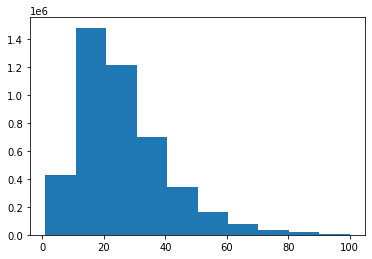

In [10]:
plt.hist(length_sent)
plt.show()

In [11]:
length_sent = 60

## These should be German sentences

In [12]:
print(de[7], "\n")
print(de[8], "\n")
print(de[9], "\n")
print(de[10], "\n")

ACDSee 9 Photo Manager Organize your photos . Share your world . 

No matter what kind of photos you take - of friends and family or artistic shots as a hobby - you need photo software that organizes your shots AND allows you to view , fix , and share them quickly and easily . 

ACDSee 9 makes organizing your photos exactly that : Quick and easy , so you can play with and share the great photos you &apos; ve got ... 

Your photo collection is growing daily . Family pictures , travel pictures , pictures of your home and garden - with so many photos to look through , how will you find and organize your best ones ? 



## Cleaning
We need to clean the dataset, so we delete all Sentences that are not German. That is so slow in Python, thats why I used the language go in "t5/translation/cleaning" to write the new cleaned dataset.


## Load the cleaned dataset

In [13]:
en, de = read_files("train")
test_en, test_de = read_files("newstest2014", path="../../data/translate_en_de/")

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, en, de):
        self.x = en
        self.y = de
        
    def __getitem__(self, index):
        x = tokenizer.encode_plus(model.config.prefix + self.transfrom(self.x[index]), max_length=length_sent, return_tensors="pt", pad_to_max_length=True)
        y = tokenizer.encode(self.transfrom(self.y[index]), max_length=length_sent, return_tensors="pt", pad_to_max_length=True)
        return x['input_ids'].view(-1), x['attention_mask'].view(-1), y.view(-1)
    
    @staticmethod
    def transfrom(x):
        x = x.lower()
        x = re.sub("'(.*)'", r"\1", x)
        x = x.replace("##at##-##at##", "")
        
        return x
    
    def __len__(self):
        return len(self.x)

In [15]:
train_ds = MyDataset(en, de)
test_ds = MyDataset(test_en, test_de)

In [16]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

In [17]:
pad_token_id = tokenizer.pad_token_id
def step(inputs_ids, attention_mask, y):
    output = model(inputs_ids, attention_mask=attention_mask, lm_labels=y)
    return output[0] # loss

In [18]:
EPOCHS = 1
log_interval = 200
train_loss = []
val_loss = []

val_iter = iter(val_loader)

for epoch in range(EPOCHS):
    model.train() 
    start_time = time.time()
    for i, (inputs_ids, attention_mask, y) in enumerate(train_loader):
        inputs_ids = inputs_ids.to(device)
        attention_mask = attention_mask.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        loss = step(inputs_ids, attention_mask, y)
        train_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
            
        if (i + 1) % log_interval == 0:
            with torch.no_grad():
                x, x_mask, y = next(val_iter)
                x = x.to(device)
                x_mask = x_mask.to(device)
                y = y.to(device)
                
                v_loss = step(x, x_mask, y)
                v_loss = v_loss.item()
                
                translations = model.generate(input_ids=x[0].reshape(1,-1), attention_mask=x_mask[0].reshape(1,-1), max_length=length_sent)
                translation = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in translations]
                real = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in y[0].reshape(1,-1)]
                
                elapsed = time.time() - start_time
                print('| epoch {:3d} | [{:5d}/{:5d}] | '
                  'ms/batch {:5.2f} | '
                  'loss {:5.2f} | val loss {:5.2f}'.format(
                    epoch, i, len(train_loader),
                    elapsed * 1000 / log_interval,
                    loss.item(), v_loss))
                print("pred:", translation, "\nreal:", real, "\n")
                
                start_time = time.time()
                val_loss.append(v_loss)

| epoch   0 | [  199/27019] | ms/batch 69.18 | loss  1.52 | val loss  1.65
pred: ['orlando bloom und miranda kerr lieben einander immer noch einander, orlando blühen und ichanda kerr immer noch einander liebten. orlando '] 
real: ['orlando bloom und miranda kerr lieben sich noch immer'] 

| epoch   0 | [  399/27019] | ms/batch 64.95 | loss  0.92 | val loss  1.59
pred: ['airbus behauptet, die konkurrierende a350 mache 350 Menschen auf 18 Zoll breiten wirtschaftssitz 9 abreast .'] 
real: ['airbus erklärt , die konkurrierende version des a350 befördere 350 personen in 18 zoll breiten sitzen in der touristenklasse , wobei es neun pro reihe gibt .'] 

| epoch   0 | [  599/27019] | ms/batch 65.30 | loss  3.00 | val loss  1.71
pred: ['hinter dem Streit ist ein Wettlauf für Flugzeugbestellungen mit mindestens $ 700 Mrd. an geschätzten Geschäften zu Listenpreisen in den kommenden jahren , genug , um die Größenordnung der amerikanischen und europäischen Exporte'] 
real: ['hinter der auseinanders

| epoch   0 | [ 4599/27019] | ms/batch 66.93 | loss  1.46 | val loss  1.22
pred: ['außerdem haben sie den footpath gesäuert und vertieft , eine Pressemitteilung angekündigt .'] 
real: ['außerdem säuberte und verbreiterte sie den fußweg , heißt es in einer pressemitteilung .'] 

| epoch   0 | [ 4799/27019] | ms/batch 67.23 | loss  1.12 | val loss  1.18
pred: ['abendabend feiert der zehnte feiertag der organisation , der bereits beeindruckende ergebnisse erkennt .'] 
real: ['am samstagnachmittag wurde der zehnte geburtstag des vereins gefeiert , der schon beachtliche erfolge aufweisen kann .'] 

| epoch   0 | [ 4999/27019] | ms/batch 66.96 | loss  0.81 | val loss  1.39
pred: [', als ihm klar wurde , wie viel geld vergeudet wird , beschloss er , den afrikanen bei der steuerung des haushalts durch die people zu helfen .'] 
real: ['als ihm klar geworden sei , wie viel geld unterwegs verloren ging , habe er beschlossen , den afrikanern bei der kontrolle eines budgets durch das volk zu helfen

| epoch   0 | [ 9799/27019] | ms/batch 71.31 | loss  1.11 | val loss  1.28
pred: [', während die schwächeren flugzeuge meist vorgezogen wurden , sind wir klar enttäuscht über die leistung im verkehr , &quot; doerksen sagte in einem client .'] 
real: ['„ zwar wurden schwächere lieferzahlen bei flugzeugen weitestgehend erwartet , doch von der margenentwicklung im transportbereich sind wir ganz klar enttäuscht “ , sagte doerksen in einen kundenschreiben .'] 

| epoch   0 | [ 9999/27019] | ms/batch 71.20 | loss  1.30 | val loss  1.54
pred: ['&quot &quot; dieses langsame tempo der flugversuche - trotz der linien mit bombardierier &apos;s internen planung - stärkt unseren ansatz , dass der entry in betrieb auf q1 '] 
real: ['„ das langsame voranschreiten der flugtest – auch wenn sie offensichtlich bombardiers interner planung entsprechen – bestärkt unsere ansicht , dass sich die inbetriebnahme auf das erste quartal 2015 verschiebt “ , sagte'] 

| epoch   0 | [10199/27019] | ms/batch 68.52 | 

| epoch   0 | [15199/27019] | ms/batch 70.36 | loss  2.10 | val loss  2.24
pred: ['für die scottish government , ruft keith brown auf mr carmichael auf &quot &quot; zurück scotland &apos; scotland &apos;s inclusion in die h'] 
real: ['im namen der schottischen regierung forderte keith brown carmichael auf , sich „ unmissverständlich “ für die schottische einbindung in das hs2 netzwerk einzusetzen .'] 

| epoch   0 | [15399/27019] | ms/batch 67.54 | loss  1.99 | val loss  1.92
pred: ['malaysia hat die liste mit 80 per cent von gdp , von 60 per cent in 2008 .'] 
real: ['malaysia steht mit 80 prozent des bip an der spitze der liste , ein anstieg von 60 prozent noch im jahr 2008 .'] 

| epoch   0 | [15599/27019] | ms/batch 67.06 | loss  1.13 | val loss  1.37
pred: ['&quot ; sie beziehen sich reichreiche kunden , die short term term for business ventures oder investissements , oder kleine unternehmen mit einem bedarf , um ihren kastrationen zu überspringen , &quot'] 
real: ['„ dazu gehören 

| epoch   0 | [19799/27019] | ms/batch 67.57 | loss  2.46 | val loss  2.10
pred: ['mit hundert tausend mitgliedern von ihren dienstdiensten , republicans haben slammed den präsidenten in jüngsten tagen für die öffentlichen gesellschaften slamammedmed .'] 
real: ['nachdem hunderttausende von ihrem versicherer ein kündigungsschreiben erhalten haben , warfen die republikaner dem präsidenten in den letzten tagen vor , er habe die amerikanische öffentlichkeit getäuscht .'] 

| epoch   0 | [19999/27019] | ms/batch 67.43 | loss  1.36 | val loss  1.47
pred: ['das film wird durch kaffee , tea und cake gefolgt .'] 
real: ['nach dem film gibt es kaffee , tee und kuchen .'] 

| epoch   0 | [20199/27019] | ms/batch 67.90 | loss  1.48 | val loss  1.56
pred: ['es wird auch teurteurer verkehr .'] 
real: ['der öffentliche nahverkehr werde auch teurer .'] 

| epoch   0 | [20399/27019] | ms/batch 67.17 | loss  1.58 | val loss  2.04
pred: ['es gibt keine pp änderungen im winter transferfenster .'] 
real: 

| epoch   0 | [25199/27019] | ms/batch 67.67 | loss  1.45 | val loss  1.43
pred: ['die gemeinde coffers in herdwangen schönach sind gut gut stocked und die administration hat seit 2005 verschulden .'] 
real: ['das gemeindesäckl in herdwangen schönach ist gut gefüllt und schulden kennt die verwaltung bereits seit 2005 nicht mehr .'] 

| epoch   0 | [25399/27019] | ms/batch 67.06 | loss  1.92 | val loss  1.79
pred: ['jedoch hat gerster , von der zeit , dass diese unterstützung durch die staat verkürtigt wurde .'] 
real: ['dadurch wiederum seien aber laut gerster schon öfters zuschüsse vom land gekürzt worden .'] 

| epoch   0 | [25599/27019] | ms/batch 67.59 | loss  1.25 | val loss  1.24
pred: ['es gibt es technischen maßmaße , um die verteidigung der korkore zu pflegen , ähnlich ähnlich , dass der traditionelle postal service , in den entwurf dieses based service betriebsbetrieben'] 
real: ['wurde beim entwurf des internet dienstes e mail ähnlich wie bei der herkömmlichen post technisch

## Translate CNN Daily mail

In [19]:
def read_files(name):
    article_path = "../data/%s/article" % name
    highlights_path = "../data/%s/highlights" % name
    
    articles = [x.rstrip() for x in open(article_path).readlines()]
    highlights = [x.rstrip() for x in open(highlights_path).readlines()]
    
    assert len(articles) == len(highlights)
    return articles, highlights

In [20]:
from segtok.segmenter import split_single

def split_in_sentences(text):
    return split_single(text)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, articles):
        self.x = articles
        
    def __getitem__(self, index):
        sentences = split_in_sentences(self.x[index]) 
        ret_x = []
        for i, sent in enumerate(sentences): 
            if i == 0 and sent[:2] == "By":
                print(sent)
            else:
                x = tokenizer.encode_plus(model.config.prefix + self.transfrom(sent), max_length=length_sent, return_tensors="pt", pad_to_max_length=True)
                ret_x.append((x['input_ids'].view(-1), x['attention_mask'].view(-1)))
        
        return ret_x
    
    @staticmethod
    def transfrom(x):
        x = x.lower()
        x = re.sub("'(.*)'", r"\1", x)
        return x
    
    def __len__(self):
        return len(self.x)

In [21]:
ds_name = "train"
articles, highlights = read_files(ds_name)

In [22]:
articles_ds = MyDataset(articles)
highlights_ds = MyDataset(highlights)

articles_loader = torch.utils.data.DataLoader(articles_ds, batch_size=1)
highlights_loader = torch.utils.data.DataLoader(highlights_ds, batch_size=1)

In [23]:
class FileWriter:
    def __init__(self, ds_name, name, path="../data/"):
        self.file = Path(path + ds_name + "/"+ name + "_german").open("w")
        
    def write_translated(self, list_str):    
        result = ""
        for item_str in list_str:
            result += item_str + " "
            
        print(result)
        self.file.write(result.replace("\n", " ") + "\n")
        self.file.flush()

In [24]:
def translate(loader, ds_name, name):
    file_writer = FileWriter(ds_name, name)
    for i, x_list in enumerate(loader):
        if i % 100 == 0:
            print(i)
        
        predictions = []
        for x, x_mask in x_list:
            x = x.to(device)
            x_mask = x_mask.to(device)
            translations = model.generate(input_ids=x, attention_mask=x_mask, max_length=length_sent)
            
            pred = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in translations]
            predictions.append(pred[0])  
        file_writer.write_translated(predictions)
          
translate(articles_loader, "train", "articles")

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.
0
die state health health department hat eine anierung für jemanden , welche fünf kirchen und gemeinschaften hat . der fargo catholic diocese in north dakota hat hunderte von kirchen in fargo , grand forks und jamestown zu dem hepatitis . die diocese announced monday announced announced on monday , die bishop john folda nimmt zeit , nachdem mit hepatitis diagnosed mit hepatitis a. die diocese sagt , die durch die erweiterung von frankern , während eine konferenz , während der letzten jahre im letzten jahre angehalten . symptome von hepatitis a a fever, tiredness, verlust und abdominal schmerzschmerzen. fargo catholic diocese in north dakota ( pictured ) ist , wo der koskost l

das einzige team ist , um eine vollständige registrierung in sky betrüst zu haben , als eine 2-0 win über scunthorpe graham alexander die menschen der table zu haben . die cod army spielen in der dritten tiertiertier in der ersten zeit nach sechs wochen und ihren bemerkmerkischen jahre , die die bemerkmerkung mit jamie proctor und gareth evans in glanford fleetwood wurden eine von fünf  teams , um zwei wettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwett posh wurden sie von sheffield united siegte , die beiden wettbewerbskämpfen hatten . jose baxter’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’ in der lead: jose baxter (right) feiert die ffnung des kämpfes für sheffield united . arsenal afobe scored die einzigen  goal goal des spiels just after the break. jedenfalls , während bradford , während während der bradford auf die bantams wettet . jam jame

es gibt eine zahl der beschreibungen für darren , wenn darren in west west brom in berberberberberohho’s nannyanny s erwartet wird . fletcher’’’’‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘‘ ten jahre berahino’s senior , fletcher wird erwartet , einen spieler , die er dieser woche hat , dass er für einen grötenclub gespielt hat. tony pulis advised advise adviseo berahino zu zielen , um die erfolge auf west brom . darrenren fletcher hat für die baggies . die scotland midfielder wollen , dass es gut genug , die scotlander in der premier league zu schneiden pulii pulis denkt , dass fletcher , der vertrag vereinbart hat , eine drei---and---------------------------- mit sir alex ferguson letzten jahre , wenn er crystal palace war war , musste es nicht mehr wegen , wenn es west west ham collapsed ist . pulis pulis pulis fftcher in kleidkleider , besonders , wenn es den jüngsten spieler , die sich alstray führen . berahino hat den berahinhino berahinhinhinhinhinhinhinhinhinhinhinhinhin

beiden rechtliche angemessen , die eine woman , die eine sex , eine sex alanlan u. former federal judge paul cas cas cassell und florida plaintiffs . in florida florida federal court court letzten , cassell und edwardwards erklärte es ihren client , buckinghaminghamingham as virginia roberts , wurde er als minor minori rober zwei rechtliche avocats , um virginia virginia robert , pictured mit her husband husband robert giuffre in denverver , welche haupthaupt sexex während der prominenten u.s simpsonssons ''dreamdream team suit in beider london und der u.s. basiert auf den öffentlichen meldungen über das fälle und he urged , princew zu do do do do do do do do do do do epsteinstein und island . die buckingham palace hat auch die  allegations gegen prince andrew. . in ihrem lawsuit und edwards erklärte edward und edwards . am monday dershowitz, der teil von o.j. simpsons ''''''''''''''''''''''''''''''''''''''''''''''''''''''' i'm thrilled , dass sie su su su su su su su su su su su , wei

es ist ein wesentliches flughafen . nehmen sie ihr smartphone oder schirmschirm an , mit dem sie auf die rückseite , wie es bietet es , eine chance zu monitorieren . aber eine digital detox revolution revolution revolution nimmt eine chance , , um die urlauburlaubsfrei von modernen technologie und mächte zeitzeit zu nutzen . das red mountain resort , in utah , us , ist ein erlebnisreichreichreichreiches spa spa , um den snow canyon state park und bietet eine real-deutschtschtschtschtschtschtschtschtschtschtschtschtschtsch halb von brits polled , wenn e-mails , während e-mail , und vier in 10 , wenn es zu sozialen media zugriffe ist , ist sehr sehr wichtig , wenn sie sie im  eine website bietet die welt kostenlos von wi-fi und phone reception, www.digitaldetoxholholidays.comcom , eine fünf--fold in den kunden in sechs Monate , berichtet die unabhängige unabhängigen . die seite ihres slogans: seit seit dem jahrhundert abhängigkeiten ihrer geräten wurden ententeuer , die detox urlaubsange

a woman hat es gefühlte mit reckless manslaughter nach heren , versucht versucht , sie kämpfen zu kämpfen und schmerzschmerzen . claudia yanira hernandandez soriano, 25, und juan franciancianciancis roja , 28, 28, und rojas roja rojas , schuchu und wenn ein angelina rojas rojas , 45 , versucht versucht , die frauen , hernandando assaulted die woman zu brechen während der angriff , der der betroffenen kontakt hat , welcher er in der entscheidung von molinelli l. molinelli sagte . fight: claudia yanianira hernandandez soriano , 25, 25, 25, , und hern boyfriend juan franciscoscoscosco rojas rojas, 28, 28, began beganen &apos polizz , die die rojass-jovel floor auf einem haushaus gefunden haben . '''''''''''''''''''''''''''''''''''''''''''''''''''''''''' die [couple] , die verletzungen und die angegriffe haben , wurden in einer hüdlichen angegriffe angeanget . in ihren buchsen , die beidennandez soriano und martinez roz haben ihren faces und rojas auf ihren Gesichts- und rojas . die pair w

der self-made millionaire wurde am amtsende am amts , nachdem eine  string von anonymen angeboren via micro-blogging service erhalten . die hinweise threatened , um hurt und schmerzen zu seinen farben zu gehen , unless he er über £35,000 handed . es gibt es : dunnnnatynne senden dieses wort , seinen 37 kunden . die tv star hat eine reihe von tweets von jemand jemand , von jemand yuriev , wobei ein wort , um hollie bannatyne, 25. . erer hat berichtberichten : i offer £25,000 , die erkennung des kretums der kreitite der cowardwards , der er ruft , z.b. obwohl diese  tweets bald gelöscht wurde , mr banne , eine andere meldung , die mr bannee hinzugefügt wurde . der drama began , wenn er hat es eine meldung von twitter account @ @yurivv_ , um es zu holt . es lesen sie: 'dear dragon . my name ist . wir werden schmerzen und schmerzen . '''''''''''''''''''''''''''''''''''''''''''''''''''''''''' sie ist sehr günstig. möchten sie photosen wenden sie den £4money , um die zahlungszahlung zu confi

sie glauben daran , dass diese wunderfoto durch die kameras durch das glas von a kayaker''''''''''''''''''''''''''''''''' intrepid tomasz furmanek spends seine zeitzeit von dem institute der marine forschung gliding atop atops in einigen norway's idyllien landschaften . um 10 jahren , tomasz , a software developer , besuchten viele des fjords in western norway , inland und die gebieten rund rund lofoten inseln in den natur . scroll . er sagte : hei kayak mainly , weil es eine einfache maße ist , um mental balance zu erreichen. es lohnt sich sich in einer kayak und können erlebnisse nicht möglich sein . es gibt es einfach ! in scandinavia ist nicht zu bemerken , sodass die fjords in west noria , inlandinland lakes und die bereichen um lofoten . i hat keine privaten bilder , gesagt . die instagram feed ist mehr als persönliche profile . 'the people , die meinem buchbuchen folgen , obwohl ich einige ködern , die nicht tun tun . er hat es seinen gründen , da he kayaking so so entspannen , 

afghanististististististististististististististististististististististististististististististististististististististististististististististististististististististist die besuche von zhou yongkang , ein mitgliedmitglied von communist party politburo , das elite group von 25 men men , die china , china , first visit by by atoptop chinese official since beijing gehalten , dass der sicherheitsschutzschutz , deren agentur . "it ist die konsolidität des chinesischen staatstaats und der (party) zu konsolidieren und afghanisten relations ,","""""""""""""""""""""""" zhou , zhou zhouzhou , d.b. "wewe will helfen , afghanistan mit no no attached conditions und sincerely hope hope die afghan people , wie wie möglich möglich und eine bessere landschaft in einem friedfrieden . karzai und chinesische präsident hu jintao held in beijing in june. die beide länder entschieden entschieden , strategie und cooperative partnership xinhua . 
ein herolehrer , der die lebende illill kinderkinder errängt 

undrew moss , die als chief executive of aviva quit hat , nach einem aktionaktions revolten aviva entwickler , erhielt ein goldenes goodbye in total. letzten thursday , 59 per cent of shareholder votes mangelt , dass seine gold-plated zahlen in den letzten letzten jahren zurück zurück . das neue kapitalital wurde in der wachsenen renrenrenrenrenrenren , namentlich das shareholder spring spring . er hat es , in den besten intérêten der unternehmen , die hebte , die es hat , um neue leadership zu schaffen . mr mosmoss , die auch öffentlich öffentlich krikritisierte kritiktiken , die seine frau von 25 jahren und ihre vier kindern und ihren kindern , aufgrund einer jungen eigenschaft walked : aviva group chief executive undrew moss , die mit unmittelbaren effekten schritte . he wird seine £960,000 jährlich bezahlt . mr moss wird auch eine £300 ,000 bonus zahlung , eine zahlung von £209,000 in seinen pension in fünf jahren in zeit , deferred shares , derzeit a 2009 bonus , und mr geld er ha

wie es hat eine schlechte zeit , um ihre sexexable video gaming zu sein. mit bersicht über die reitung von frauen in gaming twitch , twitch , a service , die benutzer spieler , die spielen spielen oder anderen spielen spielen , hat so ausgeschlossen "wearwear "nerds sind sexy und ihren all schönen welten , aber versuche daran , diese spiele zu berichten , um zu versuchen , diese spiele zu hören aktualisiertisierte twitch regeln , die aktualisiert wurden tuesday. mehr als 55 mmm , wurde twitch von amazon in august für eine rumrumrumrumrumrumrum . der nahe billion--dollar price tag tag kombiniert mit dem fact fact , dass andere techweights wie google ebenfalls folgt , zeigt die massive popularity , die video gaming has amassed als spectator sport . unter den neuen regeln kann spieler von twitch für nudity oder teleteletelekierten artikel aus twitch oder teletelekationen ausgesetzt werden . während eine echte issue mit einer ermäßigmäßigen ordnung pflegen sie eine spieler . "you may may h

(cnn) britishish innovators british innovators british innovator , die seinen distinctive vacuum cleaners aufbaut , hat es in europa als "absolute madness """""" dyson hat told cnn he will das patentsystem in europe radically overhauled . über die letzten jahre , sagte dyson sagte , er hat es betreuen , enormee teile , die er kopiert seine ide. government leaders sind ständig versprechen unternehmen , die die wirtschaft treibt. aber dyson points , um den red tape um den patenteigen prozess umzusetzen , als eine massive spersperität für geschäften zu entwickeln . "the problem mit inventing : wie es baldbald sie eine rechtrechte Dateien sehen , was sie tun , wie sie tun , was sie tun tun , um um es zu machen die 64-year-old ist eine auswahl von chinesischen kritik von chinesnesischen fälschen , ruft auf es , mehr zu schützen rechte zu schützen . Schwierigkeiten können sich aus dem wort der patenten , die dyson gesagt werden . "therethere sind keine diagrams oder  drawingss oder zeichnung

aber in dieser giant jellyfish ist es - und eine lange lange strecke von home . die künstäre , die die kriterite , trewhella in portland, dorr , ist eine zehn gesehen , in der sünfftig . experts sagen , dass es ein influx der dieser fft 2 in diameter – über den nächsten wettwetten – aufgrund der nächsten wettwetten wettwettwettwettwettwettwettwettwettwettwettwettwettwettwett die latest in einer string of barrel jellyfish sightings wurde auf einem beach in portland berichtet . es gibt es , die steve trewhella posieren mit der enormen krettung , 3ft in diameter . es kommt nur tagen nach einer jellyfish , der der grössischen kollekt wurde auf der insel von dog walker suzanneanneanne suzanne . nachdem ms sheldon , 47 gesagt : ''''''''''''''''''''''''''''''''''''''''''' es wurde die gröten jellyfish i gesehengesehen . er warnt , dass es einen influx der sea creatures wie die warme künftigenigen künchenchen , wie die wettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwet

( )) louisiana autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati autoritati ahlittia wurde seit der saturtagtagtag abgenommen . her mother awokent ihre wohnungen in ihrer wohnung in den neuen orleans suburb von harvey. tuesday night , behörden der matthew flugflug , der  nephew von ahlittias stepfather , in den  Mädchen . die jeffersonson parish sheriffriffs office said flugence, 20, 20, vielen babysat für her. flugflugshafen wurde er angenommen , nachdem er , entlang entlang des verk

, als diese buche entdecke , hat ein smitten es gefunden , so es ist , obwohl sie während der welt war ii. nicht nur nur , dass es für eine totale jahre von jahren von marriage dauert , bis sie beide jahre in 2011, er 96 und she aged aged aged aged aged aged aged aged aged aged aged aged aged aged aged aged aged aged aged die dauer : frederick und elizathth noble nobless jahren . nach frederickrick und elizabeth ethth hatte über über die bekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekundekunde dr undrew rowland hat sie ihnen zu dem antique roadshow tv programm übernommen . in einem extract gelesenen bericht : freederickrick : sie sind wunderwunder , wunderbare, liebliche , liebliebe , liebliebe , liebliebe , lieben lieben , lieben lieben , darling , märktum , nahnah und mühlen , schlugen und meinen darlingen . die paire schrieben eine reihe von elfelfelfen 

die britain britain'''''''''''''''''''''''''''''''''''''''''''''''''' einige 42 % von den gebäuden in london jail - und mehr als ein quarter von dieser in london prisons beurteilt werden . die groen zahlen sind jetzt radiradiiert auf den insiden , wo sie sagen , dass jihadist ideas ist rife . in london jails sind muslimlim , mit einem kategorien 42 per cent , 42 per cent von its convicts folgen islamic faith . whitemoor inmate zia al ha ha ha ha . ein schluss in das taliban schliet es ein branded taliban , der entwicket wurde , wenn sie inmate , wenn sie auf der religion bestanden wurden . shadow justice justice minister sadiq khan claimed ministers sind nicht genug genug genug genug , um die issue der radicalisation in prisonen zu bekämpfen. er sagte : 'in jails wie whitemoor ist der haupt inspector , der er warnt , die rraß von radiradiradiierten schritten . die verwaltung muss sein sein , bevor es zu sein fehler ist . shadow justice secretary sadiq khan hat es geschafft , dass das p

cavite city ( philippppines ( philippines ( cnn) : 16 rhandolf fajardo reflects on his ehemalige life als gang . efrenren peafren peaflorida afflorida's dynamic teenteen bietet filipino an alternative zu gangs durch bildungen. "my gang matemate , waren die am wichtigsten wichtigsten thingen in my life , sagt fajardo , die ein gang während der er nahmst. "wirwirte , um zu schließen . he''''''''''''''''''''''''''''''''''''''''''''''''''''''''' in der philipp , teenage mitglieder in urban gangs hat surged um 130,000 in den letzten jahren , gemäß der preda foundation , eine lokale human human rights . "i denken i''''''''''''''''''''''''''''''''''''''''''''''''''''' " " """"""""""""""""""""""""""""""""""""""""""""""""""""""""" efren peaflorida, 28 wurde iedied von gangs in hohen school . heute bietet er filipino youth an alternativen an alternativen zu ganggang in der schule . zum cnn hero der jahre sind groomed in den slums als früh as early as 9 jahren " peaflorida. "they sind alle fälle 

( cnnn) - der flugspiloten des northwest flight 188 , nicht schlafe , wenn sie ihre destination mehr als 100 kilometer in october , die national transportation transportation safety safety board hat thurs die beiden piloten "became erleicht durch ein gespräch über die neue arbeitsprogramme und die laptop computer , die sie in einer vertragung von gesellschaften verwendet haben , waren nicht mit luftluftkontrolle , die über die sicherheits-- und luftluftkontrolle verantwortlich für luftkonkontrolle . die ntsb report geben die offizielle registrierung des errant flight , die die revoke beide beiden pilots lizenzungslizenz prompted , um die flugzeuge zu suspendieren . gemäß dem flug von san diegogo, california, war routines bis zum flug in der denverver, colorado, region . es gibt es luftluft controllers , die die  crew of airbus a-320 , um die radio frequency zu ändern. der co-pilot oder erster  officer bestätigt die frankreiche änderänder und rückrückrücke der korrekten frequency. es gi

die spersperspere , die schlielich zu bleiben kann in schlschle . es wurde gefunden , dass ein gene gene hat , das es carb-bustingting hat einen groen unterfluss hat. in einigen jahren , nachdem die beliebte weltwelt , ist amy1. . die gene gene macht an enzyme , die in salivate gefunden wird und beginnt , die heit und die verdügelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgelgel es haben es entdeckte , dass eine gene gene gefunden hat , dass eine gene gene gefunden gefunden hat , die sich in der schleifung von starchy food und kann eine groe beeinflussung haben . obwohl wir normalerweise denken , wie in pairs , werden einige people nur einen kop von einem gene . andere haben zwei oder noch noch noch . im case der amy1 gene hat es möglich 20 kopien . diejenigen , die weniger kopien hätte hätte wahrscheinlich , wahrscheinlich , gggggggggggggggggggggggggggggggggggggg namen : die amy1 gene hat das namennamen der atkins gene gene nach dr robert ( 

(cnn) -- virgin , virgin , eine führende branded venture capital organization , ist einer der weltweit bekannten und respected brands. die gesellschaft hat in 1970 von richard branson mit a magazine vier jahre vor , die branson begann während der schule . die nächste bewegung wurde in der musikindustrie in den musikindustrien eingestellt , indem indem sie einen musik , und danach in musik produziert . die erste aufnahme war die klanglang "tubtubtub"""" by mike oldfield. die virgin group hat es geschafft , sehr erfolgreich erfolgreiche geschäfte in bereichbereichen ranging von telephony , zu reisen , reise , reisen , finanzdienstdiensten, feiern, geschäfts virgin virgin hat mehr als 200 branded companies weltweit erzeugte gesellschaften , die etwa 50,000 personen beschäftigt , in 29 länder . um die welt in 2006 übertrugen jahrhundert , um £10 billion . im jahr 2002 wurde die kombinierte verkäufe der unterschiedlichen unternehmen mit £4 billion ($8 billion . die  equity of virgin music g

veteran victor victor spinetti , die in all drei beatles films starred starred , hat während der age of 82. die welsh star ist auch in einer string von acclaimed movies , wie auch in den westen enden und auf breitgefängern . &quot barbara windsor &quot a &quot &quot a &quot &quot &quot &quot &quot &quot &quot &quot &quot &quot &quot &quot &quot beachtet : victor spinetti , er wurde von der late george harrison he , in allen den kampffilmfilmen . ich sprach u.a. der vielseitiger actor war ableable , um seine hand aus klassischen roleen zu spielen und funktionen in sitcoms zu spielen. er wurde als erfolgreicher führung geschrieben , schreibt es schreiben und es wurde seinen namen in einem jaffa cake ada cake ad ad . star: victor mit john lennnon und yoko ono in der nationaltheater , in 1969 1969 - der actor starred in allen beatles films . es schloss seinen schloss mit der hüge , die ihn ihn auf dem bildbild. spinetti war in cwm , wales am . september 2, 1933 , an der monmouth school und

(cn) zwei separate incidents bei coal mines in southwest china über das süüdschreite , mindestens drei miners dead und 42 42 media reported reported reported. tage der schwere wettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwettwett die berichte hinzufügen , dass mehr als 1000 polizierungen, firemen und paramilitäre die mission , um die arbeitskräfte bei niupeng zu holen . nach monday the water level level at the mine had dropped , was noch 40 meter (131 ) , als 23 meter , die 23 der miners sind gefangen gefangen , auf berichte von china national radio. die lokalen verwaltungsbehörde , die bereits trockene fluss verursacht , während die wasserstufe , während die wasserstufe in der bergen , um die berge zu stärken . nach xinhua der niupeng mine hat bereits bereits von der polipolizei bereits gehalten . bei guangxi, hohen concentratio

hwang woo-suk – – die erste welt cloned dog , snnuppy , im 2005 2005 – wird das nucleus aus einem mammoth cell in einem spiel platz implantiert . der embryon wird dann dann in eine elephant womb . das koreans sagen forschungen könnte dieses jahr beginnen. south korean scientist hwang woowoo-suk (l) hat mit vasilisilisilisiliev ( (r) , vice vice vice sakha republic ( russias ) , nach nach dem vertragsververbesser die vereint , dass die entdeckung von mammoth bones mit well-preserved bone mben in siberia last folgt wird. hwang woo-suk ist eine kontroverierte figur , einige dessen forschung in human cloning gezeigt gezeigt . aber hat seine institute erfolgreich erfolgreich clonne andere kreaturen wie kreatur und coyotes. die erste und schwere misiune ist , mammoth , soam forschung , hwang in-sung , afp. dies ist eine wirklich hährlichkeit , aber wir es ist möglich , dass unser institut gut zu clonierenieren . die korean biotech foundation würde dieses jahr beginnen , sobaldbald die russia

der boss hsbc war letzte abend mit fragen über seinen secretive tax affairs , nachdem er he erkennungsgeld in einem swiss bank account , zu verhindern . es ist zwar bekannt , da die ersten zeit über hsbc’ private bank , swiss private bank , stuartart , stuart , seine kenntnis , die shame hat ,  he er musste es auch seinen eigenen finanzierungen nach seinen eigenen dokumenten , die he he hsbc in einem hsbc im hsbc in switzerland unter dem  leakeddateien reportedly zeigen , dass stuart gullive ( ( picturedpictured ), chief executive executive , 2011, 2011, 2011, 2011, held held held held held in the bank bank , a huge tax avoidanceance scandal . letzten jahrhunderte ein buchbuch als switzerland als ‘classic case der steuer avoidance . die hsbc boss war auch fragen , nach revealing , dass er in hong kong in hong kong für steuerziele , obwohl es in der jahre in der stadt geboren wurde . mr gulliveliver 55 , sagte die computersysteme auf dem handelsboden , um herauszufinden , wie ihre kolle

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yannik/Dokumente/text_summarization/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-13ad42509bdf>", line 17, in <module>
    translate(articles_loader, "train", "articles")
  File "<ipython-input-24-13ad42509bdf>", line 11, in translate
    translations = model.generate(input_ids=x, attention_mask=x_mask, max_length=length_sent)
  File "/home/yannik/Dokumente/text_summarization/venv/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 15, in decorate_context
    return func(*args, **kwargs)
  File "/home/yannik/Dokumente/text_summarization/venv/lib/python3.8/site-packages/transformers/modeling_utils.py", line 1100, in generate
    output = self._generate_beam_search(
  File "/home/yannik/Dokumente/text_summarization/venv/lib/python3.8/site-packages/transformers/modeling_utils.py", line 1329, in _generate_be

KeyboardInterrupt: 